In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
# 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("/content/drive/My Drive/pytorch/罪名预测3") 

Mounted at /content/drive/


In [1]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import pickle
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import predict as predict

In [3]:
num_words = 80000
maxlen = 400
# fact数据集
fact = np.load('./data_deal/big_fact_pad_seq_%d_%d.npy' % (num_words, maxlen))
fact_train, fact_test = train_test_split(fact, test_size=0.05, random_state=1)
del fact

# 标签数据集
labels = np.load('./data_deal/big_labels_accusation.npy')
labels_train, labels_test = train_test_split(labels, test_size=0.05, random_state=1)
del labels


In [4]:
num_words = 80000
maxlen = 400
print('num_words = 80000, maxlen = 400 ')
# data_transform.get_DataSet()
device = "cuda" if torch.cuda.is_available else "cpu"

fact_train = torch.Tensor(fact_train).to(device)
labels_train = torch.Tensor(labels_train).to(device)
fact_test = torch.Tensor(fact_test).to(device)
labels_test = torch.Tensor(labels_test).to(device)

num_words = 80000, maxlen = 800 


In [5]:
print(fact_train.shape)
print(labels_train.shape)
print(fact_test.shape)
print(labels_test.shape)

torch.Size([146862, 400])
torch.Size([146862, 195])
torch.Size([7730, 400])
torch.Size([7730, 195])


In [22]:
train_ds = TensorDataset(fact_train, labels_train)
train_dl = DataLoader(train_ds, batch_size = 32)

test_ds = TensorDataset(fact_test, labels_test)
test_dl = DataLoader(test_ds, batch_size = 32)

In [23]:
class Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, output_size)
        self.relu = torch.nn.ReLU()
    def forward(self,x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        return x

device = "cuda" if torch.cuda.is_available else "cpu"
model = Model(fact_train.shape[1], labels_train.shape[1]).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_losses = []
train_acces = []
# 用数组保存每一轮迭代中，在测试数据上测试的损失值和精确度，也是为了通过画图展示出来。
eval_losses = []
eval_acces = []
batch_count = 0
for epoch in range(30):
    train_loss = 0
    train_acc = 0
    n1=0
    model.train()   # 训练模型
    num_correct = 0
    for xb, label in train_dl:
        out = model(xb)
        loss = loss_func(out, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        num_correct += (out.argmax(dim=1) == label.argmax(dim=1)).sum().item()
        # out.max()[1]取出概率最大值的索引位置
        n1 += label.shape[0]
        # print("num_correct:", num_correct,"\nn1: ",n1)
        batch_count += 1
    train_losses.append(train_loss / batch_count)
    train_acces.append(num_correct/n1)

    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in test_dl:
            # X = X.permute(1,0)    # fact转置
            if isinstance(model, torch.nn.Module):
                model.eval() # 评估模式, 这会关闭dropout
                acc_sum += (model(X).argmax(dim=1) == y.argmax(dim=1)).float().sum().item()
                model.train() # 改回训练模式
            else: # 自定义的模型
                if('is_training' in model.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (model(X, is_training=False).argmax(dim=1) == y.argmax(dim=1)).float().sum().item() 
                else:
                    acc_sum += (model(X).argmax(dim=1) == y.argmax(dim=1)).float().sum().item() 
            n += y.shape[0]
        eval_acces.append(acc_sum / n)
    
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Acc: {:.6f}'
          .format(epoch, train_loss/batch_count, num_correct/n1, acc_sum / n))

print('训练完成')
plt.plot(np.arange(len(train_losses)), train_losses,label="train loss")

plt.plot(np.arange(len(train_acces)), train_acces, label="train acc")

plt.plot(np.arange(len(eval_losses)), eval_losses, label="eval loss")

plt.plot(np.arange(len(eval_acces)), eval_acces, label="eval acc")
plt.legend() #显示图例
plt.xlabel('epoches')
#plt.ylabel("epoch")
plt.title('Model accuracy&loss')
plt.show()


epoch: 0, Train Loss: nan, Train Acc: 0.001818, Eval Acc: 0.001940
epoch: 1, Train Loss: nan, Train Acc: 0.001798, Eval Acc: 0.001940
epoch: 2, Train Loss: nan, Train Acc: 0.001798, Eval Acc: 0.001940


KeyboardInterrupt: 

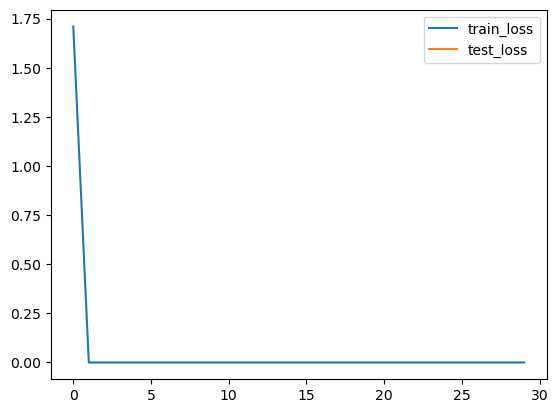

In [15]:
# 整体的Loss的走势
plt.plot(range(len(train_losses)), train_losses, label = "train_loss")
plt.plot(range(len(eval_losses)), eval_losses, label = "test_loss")
plt.legend()

In [16]:
torch.save(model,'./model/dnn2.pth')

In [20]:
with open('./data_deal/accusation_type_list.pkl', mode='rb') as f:
    accusation_all_list = pickle.load(f)
model.eval()
a = input("请输入需要预测罪名的案件详情,退出请输入0\n")
sequence = predict.get_sequence(a, num_words=80000, topK=20, word_len=2, maxlen=800)
out = model(sequence)
print(out)
out = int(out.argmax(dim=1))
print(accusation_all_list[out])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\CHRIST~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.357 seconds.
Prefix dict has been built successfully.


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]], device='cuda:0', grad_fn=<ReluBackward0>)
单位行贿
